We are exploring a data set containing a single file which compares various booking information between two hotels: a city hotel and a resort hotel.
We are focused on the aspect of cancellation of reservations at hotels after booking.

In [2]:
import pandas as pd

# Read the CSV file
hotelbooking = pd.read_csv('hotel_bookings.csv')

hotelbooking = hotelbooking.dropna(subset=['country'])

# Counting hotels
count_H1 = (hotelbooking['hotel'] == 'Resort Hotel').sum()
count_H2 = (hotelbooking['hotel'] == 'City Hotel').sum()
print(f"Number of Resort Hotels: {count_H1}\nNumber of City Hotels: {count_H2}")


Number of Resort Hotels: 39596
Number of City Hotels: 79306


In [2]:
count_canceled = (hotelbooking['is_canceled'] == 1).sum()
count_not_canceled = (hotelbooking['is_canceled'] == 0).sum()
print(f"Number of guests who canceled reservation: {count_canceled}\nNumber of guests who did not cancel the reservation: {count_not_canceled}")


Number of guests who canceled reservation: 44157
Number of guests who did not cancel the reservation: 74745


In [3]:
customer_types = hotelbooking['customer_type'].value_counts()
most_reservations_type = customer_types.idxmax()
most_reservations_count = customer_types.max()
print(f"Customer type with the most reservations is {most_reservations_type} with {most_reservations_count} reservations")


Customer type with the most reservations is Transient with 89174 reservations


In [4]:
max_spaces = hotelbooking['required_car_parking_spaces'].max()
customers_with_max_spaces_count = (hotelbooking['required_car_parking_spaces'] == max_spaces).sum()
print(f"{customers_with_max_spaces_count} customers required the most number of parking spaces {max_spaces}.")


2 customers required the most number of parking spaces 8.


In [5]:
min_spaces = hotelbooking['required_car_parking_spaces'].min()
customers_with_min_spaces_count = (hotelbooking['required_car_parking_spaces'] == min_spaces).sum()
print(f"{customers_with_min_spaces_count} customers required the least number of parking spaces {min_spaces}.")


111592 customers required the least number of parking spaces 0.


In [6]:
number_of_requests = hotelbooking['reserved_room_type'].notnull().sum()
number_of_successes = (hotelbooking['reserved_room_type'] == hotelbooking['assigned_room_type']).sum()
percentage = (number_of_successes / number_of_requests) * 100
print(f"{percentage:.4f}% of the people who expressed a room preference during reservation got the room during check-in.")


87.6377% of the people who expressed a room preference during reservation got the room during check-in.


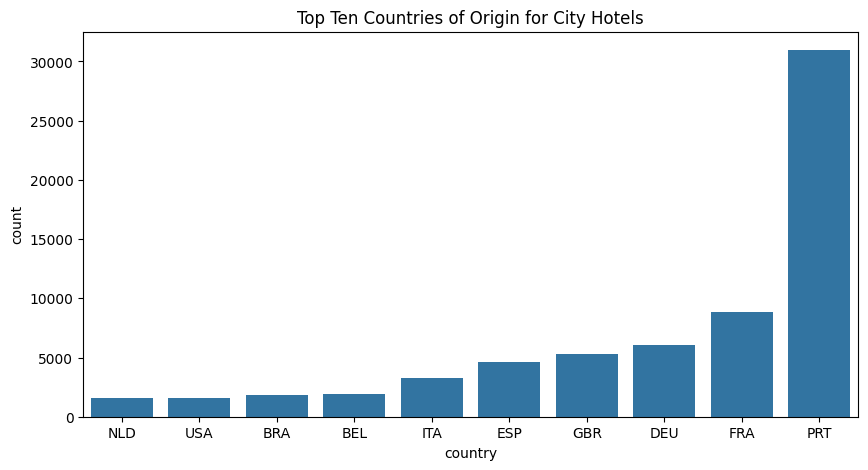

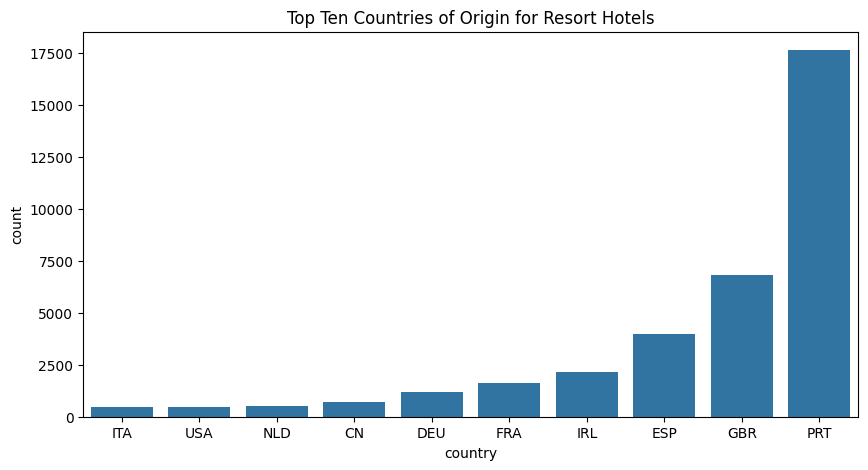

In [7]:
# First, we need to extract the data for city and resort hotels separately
city_hotels = hotelbooking[hotelbooking['hotel'] == 'City Hotel']
resort_hotels = hotelbooking[hotelbooking['hotel'] == 'Resort Hotel']

# Then, we count the top ten countries for each type of hotel
top_ten_cities = city_hotels['country'].value_counts().head(10)
top_ten_resorts = resort_hotels['country'].value_counts().head(10)

top_ten_resorts_sorted = top_ten_resorts.sort_values(ascending=True)
sorted_index_resorts = top_ten_resorts_sorted.index
top_ten_cities_sorted =top_ten_cities.sort_values(ascending=True) 
sorted_index_cities = top_ten_cities_sorted.index

# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_index_cities, y=top_ten_cities_sorted)
plt.title('Top Ten Countries of Origin for City Hotels')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_index_resorts, y=top_ten_resorts_sorted)
plt.title('Top Ten Countries of Origin for Resort Hotels')
plt.show()


In [8]:
# Part 2.1-H (i)
print("PRT (Portugal)")

# Part 2.1-H (ii)
print("We can infer from this that the dataset likely originated in or geographically near Portugal.")


PRT (Portugal)
We can infer from this that the dataset likely originated in or geographically near Portugal.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold


# Numeric features that we can use directly
numeric_features = [
    'lead_time', 
    'previous_cancellations', 
    'total_of_special_requests', 
    'required_car_parking_spaces',
    'adr',
    'adults',
    'children',
    'babies',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'days_in_waiting_list',
    'is_repeated_guest',
]


# Categorical features that we need to one-hot encode
categorical_features = [
    'country', 
    'market_segment', 
    'customer_type', 
    'deposit_type', 
    'meal', 
    'reserved_room_type', 
    'assigned_room_type', 
    'distribution_channel',
    'hotel',
    'agent',
    'company'
]

# adr = average daily rate (a.k.a. money per day for an occupied room)
hotelbooking = hotelbooking.fillna(0)

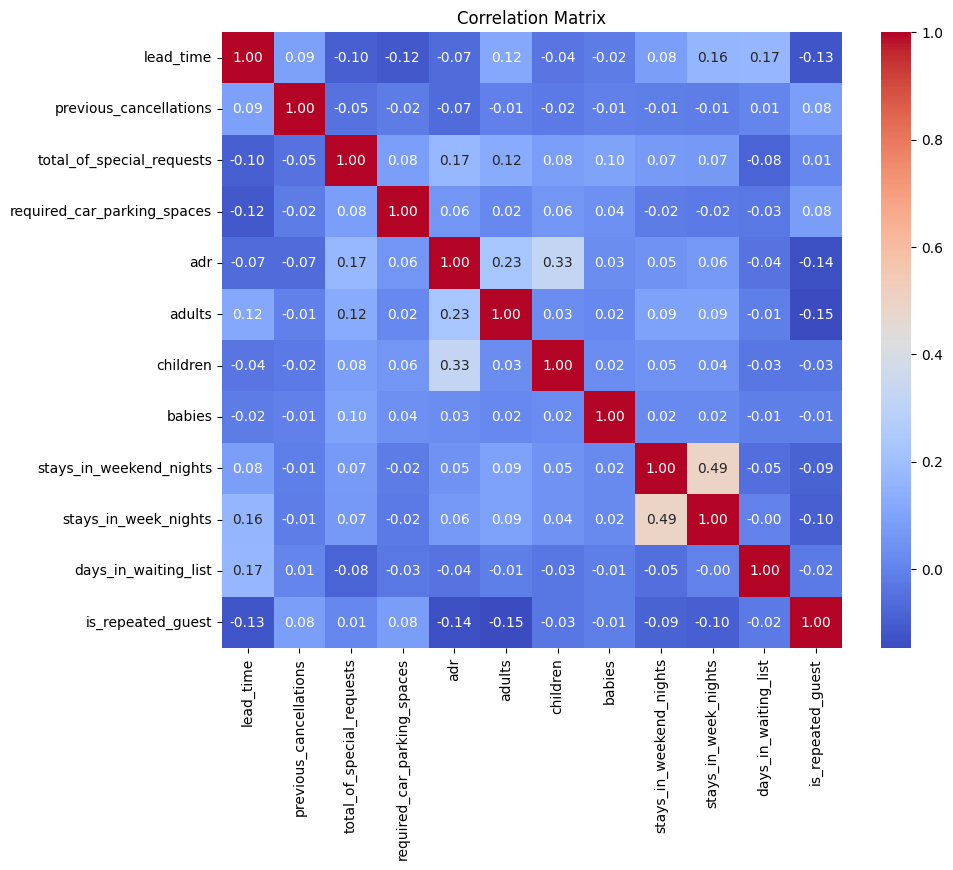

In [10]:
# 1. Correlation Between Features
# Calculate the correlation matrix for numeric features
corr_matrix = hotelbooking[numeric_features].corr() # pearson correlation coefficient by default
# the Pearson correlation coefficient is a measure of linear association between two continuous variables
# it doesn't apply to categorical data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
# 2. Impact on Target Variable
# Train a random forest model to get feature importances
# One-hot encode categorical features
hotelbooking_encoded = pd.get_dummies(hotelbooking, columns=categorical_features)

# Combine numeric and new one-hot encoded categorical feature names
# numeric_features_encoded = numeric_features.copy()
# categorical_features_encoded = [col for col in hotelbooking_encoded.columns if col.startswith(tuple(categorical_features)) and col not in numeric_features_encoded]
numeric_features_encoded = numeric_features
categorical_features_encoded = [col for col in hotelbooking_encoded.columns if col.startswith(tuple(categorical_features)) and col not in numeric_features_encoded]

selected_features = numeric_features_encoded + categorical_features_encoded

# we want to drop 'adr' because it doesn't make sense to use it in the prediction of whether the client will cancel or not
# selected_features = [feature for feature in selected_features if feature != 'adr']

# selected_features = ['lead_time', 'total_of_special_requests', 'country', 'stays_in_week_nights']


X = hotelbooking_encoded[selected_features]
y = hotelbooking_encoded['is_canceled']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1122)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1122)  

# Fit the RandomForestClassifier
# we use default number of trees = 10
model = RandomForestClassifier(random_state=1122)
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')


Cross-validation accuracy scores: [0.88360456 0.88600143 0.88334735 0.88780488 0.88566022]
Average cross-validation accuracy: 88.53%
Standard deviation of the accuracy scores: 0.16%


-------------------------------------------------------------------------------------------------------------------------

Standard deviation of 0.16% means that the model performance is stable across the folds. --> Variance is low.
Accuracy of 88.53% is good and is acceptable for predicting cancellations of reservations.

-------------------------------------------------------------------------------------------------------------------------



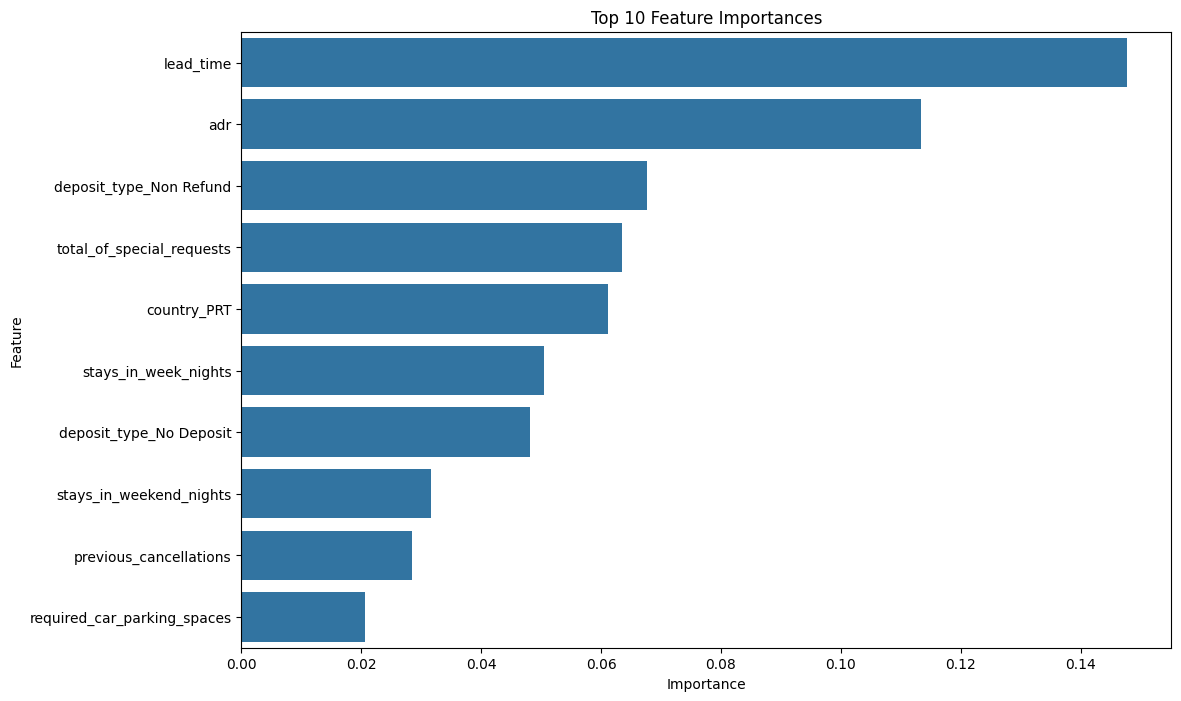

Training set accuracy: 99.57%
Validation set accuracy: 88.02%
Test set accuracy: 87.89%


In [12]:
model.fit(X_train, y_train)
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature importances
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

train_accuracy = model.score(X_train, y_train)
print(f"Training set accuracy: {train_accuracy:.2%}")

val_accuracy = model.score(X_val, y_val)
print(f"Validation set accuracy: {val_accuracy:.2%}")

test_accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2%}")

-------------------------------------------------------------------------------------------------------------------------

We see that our model performed well on the training set and now on the validation set as well. This means that our model is not overfitting or at least not too much. We most probably have to decrease the number of the features and/or increase the number of trees in the RandomForestClassifier.
Thus, it is expected and normal to see good results on the test set

-------------------------------------------------------------------------------------------------------------------------


In [13]:
# 3. Independence Assumptions
# Calculate VIF for numeric features to check for multicollinearity
# VIF = Variance Inflation Factor ==> We use it to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features_encoded
vif_data['VIF'] = [variance_inflation_factor(hotelbooking[numeric_features].values, i)
                   for i in range(len(numeric_features))]

print(vif_data)

                        feature       VIF
0                     lead_time  2.130399
1        previous_cancellations  1.030728
2     total_of_special_requests  1.631754
3   required_car_parking_spaces  1.092929
4                           adr  5.416790
5                        adults  6.741663
6                      children  1.194467
7                        babies  1.017923
8       stays_in_weekend_nights  2.494040
9          stays_in_week_nights  3.601795
10         days_in_waiting_list  1.056832
11            is_repeated_guest  1.043208


-------------------------------------------------------------------------------------------------------------------------
Here we see a strong multicollinearity in 'adr' and 'adults'. This is why we should probably just drop so that they don't misrepresent data in future results.
What's more, we now know which features are considered the most important for the model training.

-------------------------------------------------------------------------------------------------------------------------

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_pred = model.predict(X_test)

# Confusion Matrix on val data
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy Val: {accuracy}\nError Val: {1 - accuracy}\nBalanced Accuracy Val: {balanced_accuracy}")
print(f"Specificity Val: {specificity}\nSensitivity (Recall) Val: {recall}\nPrecision Val: {precision}")
print(f"F1 Score Val: {f1}")
print(f"ROC AUC Score Val: {roc_auc}") # it tells us how efficient the model is

print()

y_pred = model.predict(X_test)

# Confusion Matrix test data
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}\nError: {1 - accuracy}\nBalanced Accuracy: {balanced_accuracy}")
print(f"Specificity: {specificity}\nSensitivity (Recall): {recall}\nPrecision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy Val: 0.5408519406248686
Error Val: 0.45914805937513137
Balanced Accuracy Val: 0.500975677215378
Specificity Val: 0.6551954560641496
Sensitivity (Recall) Val: 0.3467558983666062
Precision Val: 0.37203358890105875
F1 Score Val: 0.35895027299947163
ROC AUC Score Val: 0.500975677215378

Accuracy: 0.8788528657331484
Error: 0.12114713426685164
Balanced Accuracy: 0.8630129575921806
Specificity: 0.9255754647339105
Sensitivity (Recall): 0.8004504504504505
Precision: 0.8650359011804795
F1 Score: 0.831490904837106
ROC AUC Score: 0.8630129575921804


The model achieved an accuracy of approximately 87.89%, indicating a high overall rate of correct predictions. The error rate of about 12.11% shows the proportion of predictions that were incorrect. The balanced accuracy, considering both specificity (92.56%) and sensitivity (80.05%), is at 86.30%, suggesting a good balance in predicting both classes. The F1 score of 83.15% and a ROC AUC score of 86.30% further indicate a strong performance, particularly in terms of the model's ability to balance precision and recall efficiently.

Conclusion --> The model performed well. It might need dimensionality reduction and feature selection as some of the features are not important and/or have strong collinearity which my disturb the results.

Now, we are going to explore the predictions when the countries are equally distributed. We chose the 7 countries represented as part of the most important features graph.

In [15]:
import pandas as pd

# Read the CSV file
hotelbooking = pd.read_csv('hotel_bookings.csv')

hotelbooking = hotelbooking.dropna(subset=['country'])

# Filter the dataset for the specified countries
countries = ['PRT', 'GBR', 'DEU', 'FRA', 'ESP', 'IRL', 'CHN']
hotelbooking_filtered = hotelbooking[hotelbooking['country'].isin(countries)]

# Count the number of instances for each country after filtering
country_counts = hotelbooking_filtered['country'].value_counts()

# Find the number of instances of the least represented country
min_count = country_counts.min()

# Perform undersampling
hotelbooking_undersampled = pd.DataFrame()
for country in countries:
    country_subset = hotelbooking_filtered[hotelbooking_filtered['country'] == country]
    # Sample min_count rows from each country subset
    resampled_subset = country_subset.sample(n=min_count, random_state=1122, replace=False)
    hotelbooking_undersampled = pd.concat([hotelbooking_undersampled, resampled_subset])

hotelbooking = hotelbooking_undersampled

# Counting hotels
count_H1 = (hotelbooking['hotel'] == 'Resort Hotel').sum()
count_H2 = (hotelbooking['hotel'] == 'City Hotel').sum()
print(f"Number of Resort Hotels: {count_H1}\nNumber of City Hotels: {count_H2}")


Number of Resort Hotels: 2457
Number of City Hotels: 4536


In [16]:
count_canceled = (hotelbooking['is_canceled'] == 1).sum()
count_not_canceled = (hotelbooking['is_canceled'] == 0).sum()
print(f"Number of guests who canceled reservation: {count_canceled}\nNumber of guests who did not cancel the reservation: {count_not_canceled}")


Number of guests who canceled reservation: 2090
Number of guests who did not cancel the reservation: 4903


In [17]:
customer_types = hotelbooking['customer_type'].value_counts()
most_reservations_type = customer_types.idxmax()
most_reservations_count = customer_types.max()
print(f"Customer type with the most reservations is {most_reservations_type} with {most_reservations_count} reservations")


Customer type with the most reservations is Transient with 5353 reservations


In [18]:
max_spaces = hotelbooking['required_car_parking_spaces'].max()
customers_with_max_spaces_count = (hotelbooking['required_car_parking_spaces'] == max_spaces).sum()
print(f"{customers_with_max_spaces_count} customers required the most number of parking spaces {max_spaces}.")


3 customers required the most number of parking spaces 2.


In [19]:
min_spaces = hotelbooking['required_car_parking_spaces'].min()
customers_with_min_spaces_count = (hotelbooking['required_car_parking_spaces'] == min_spaces).sum()
print(f"{customers_with_min_spaces_count} customers required the least number of parking spaces {min_spaces}.")


6608 customers required the least number of parking spaces 0.


In [20]:
number_of_requests = hotelbooking['reserved_room_type'].notnull().sum()
number_of_successes = (hotelbooking['reserved_room_type'] == hotelbooking['assigned_room_type']).sum()
percentage = (number_of_successes / number_of_requests) * 100
print(f"{percentage:.4f}% of the people who expressed a room preference during reservation got the room during check-in.")


87.9451% of the people who expressed a room preference during reservation got the room during check-in.


--------------------------------------------------------------------
Now, we are only going to work with the numeric and categorical feature that were considered the most important in the previous part.
--------------------------------------------------------------------
--------------------------------------------------------------------

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier  # or RandomForestRegressor for regression tasks
from sklearn.model_selection import train_test_split

# Numeric features that we can use directly
numeric_features = [
    'lead_time', 
    'total_of_special_requests', 
    'adr',
]

# Categorical features that we need to one-hot encode
categorical_features = ['country', 'deposit_type']

hotelbooking = hotelbooking.fillna(0)

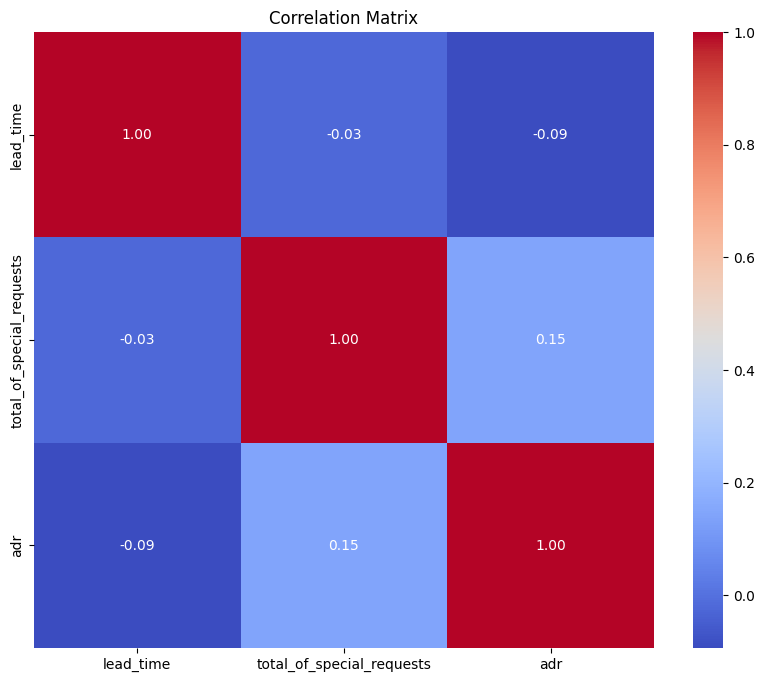

In [22]:
# 1. Correlation Between Features
# Calculate the correlation matrix for numeric features
corr_matrix = hotelbooking[numeric_features].corr() # pearson correlation coefficient by default
# the Pearson correlation coefficient is a measure of linear association between two continuous variables
# it doesn't apply to categorical data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [23]:
# 2. Impact on Target Variable
# Train a random forest model to get feature importances
# One-hot encode categorical features
hotelbooking_encoded = pd.get_dummies(hotelbooking, columns=categorical_features)

# Combine numeric and new one-hot encoded categorical feature names
# numeric_features_encoded = numeric_features.copy()
# categorical_features_encoded = [col for col in hotelbooking_encoded.columns if col.startswith(tuple(categorical_features)) and col not in numeric_features_encoded]
numeric_features_encoded = numeric_features
categorical_features_encoded = [col for col in hotelbooking_encoded.columns if col.startswith(tuple(categorical_features)) and col not in numeric_features_encoded]

selected_features = numeric_features_encoded + categorical_features_encoded

# we want to drop 'adr' because it doesn't make sense to use it in the prediction of whether the client will cancel or not
# selected_features = [feature for feature in selected_features if feature != 'adr']

# selected_features = ['lead_time', 'total_of_special_requests', 'country', 'stays_in_week_nights']


X = hotelbooking_encoded[selected_features]
y = hotelbooking_encoded['is_canceled']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1122)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1122)  

# Fit the RandomForestClassifier
model = RandomForestClassifier(random_state=1122)
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')

Cross-validation accuracy scores: [0.79985704 0.7891351  0.78984989 0.78969957 0.79971388]
Average cross-validation accuracy: 79.37%
Standard deviation of the accuracy scores: 0.50%


---------------------------------------------------------------------------

The model seems to be stable (low variance) as the STD is 0.50%.
The accuracy of the model is good but it seems that we might have cut too many features which results in 8% worse performance.

---------------------------------------------------------------------------


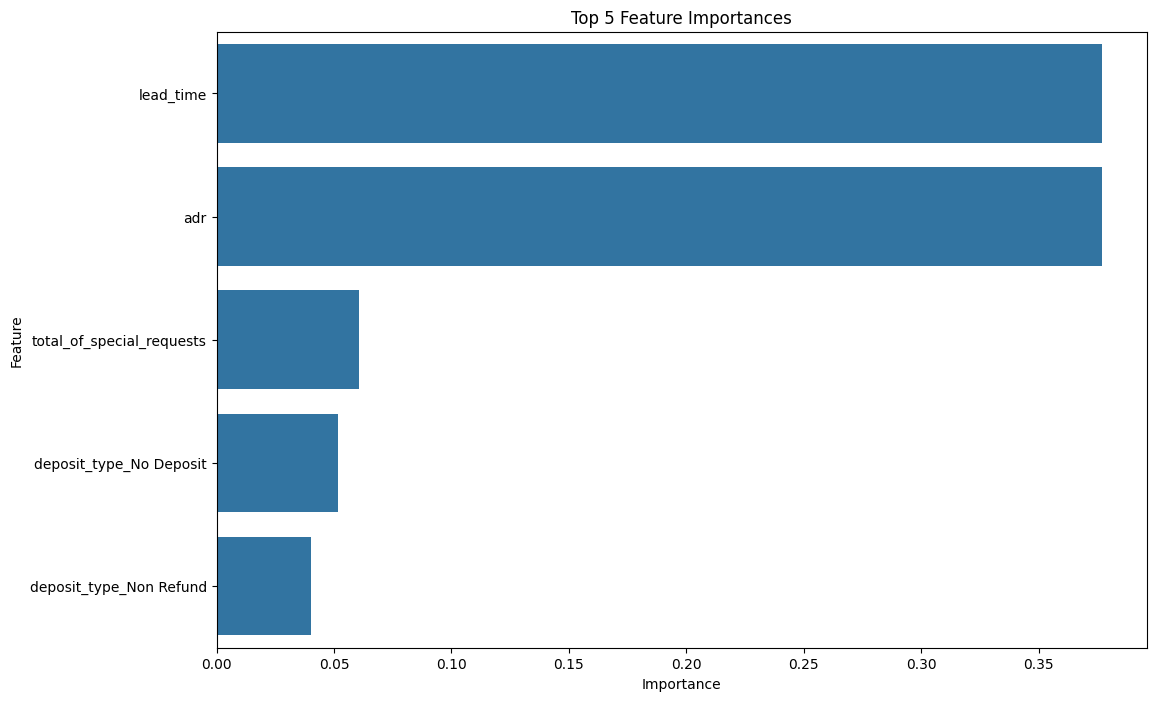

Training set accuracy: 99.95%
Validation set accuracy: 77.91%
Test set accuracy: 80.41%


In [24]:
model.fit(X_train, y_train)
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature importances
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(5))
plt.title('Top 5 Feature Importances')
plt.show()

train_accuracy = model.score(X_train, y_train)
print(f"Training set accuracy: {train_accuracy:.2%}")

val_accuracy = model.score(X_val, y_val)
print(f"Validation set accuracy: {val_accuracy:.2%}")

test_accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2%}")

---------------------------------------------------------------------------

We can see noticeable overfitting as there is a discrepancy between the training set accuracy and validation set accuracy. This indicated that the model needs tuning. Perhaps, we should increase the number of trees in the RandomForestClassifier. --> This is our next step.

---------------------------------------------------------------------------


In [25]:
# Fit the RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=1122)
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')

Cross-validation accuracy scores: [0.74839171 0.75625447 0.75553967 0.72460658 0.74463519]
Average cross-validation accuracy: 74.59%
Standard deviation of the accuracy scores: 1.15%


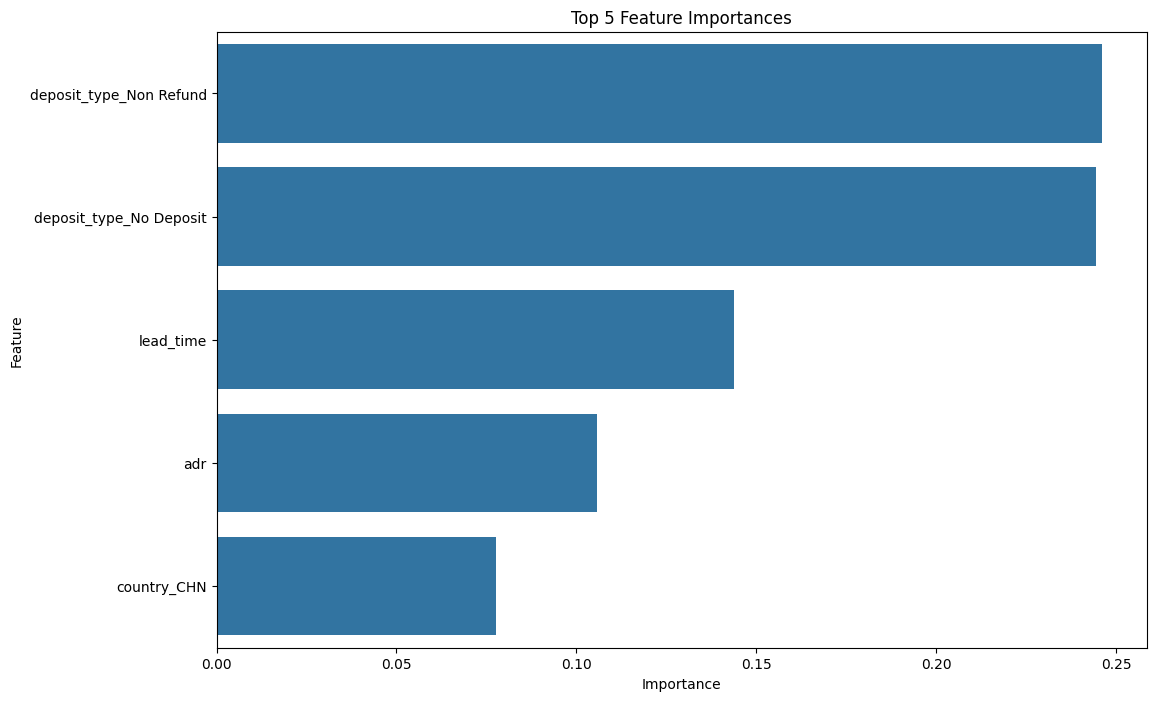

Training set accuracy: 74.66%
Validation set accuracy: 74.27%
Test set accuracy: 74.84%


In [26]:
model.fit(X_train, y_train)
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature importances
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(5))
plt.title('Top 5 Feature Importances')
plt.show()

train_accuracy = model.score(X_train, y_train)
print(f"Training set accuracy: {train_accuracy:.2%}")

val_accuracy = model.score(X_val, y_val)
print(f"Validation set accuracy: {val_accuracy:.2%}")

test_accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2%}")

---------------------------------------------------------------------------

After increasing the number of the trees in the RandomForestClassifier and manually selecting (decreasing) the max_depth of trees to be 3, we see less of overfitting. However, the performance of our model suggests that we used too few features and the model can't learn well.

---------------------------------------------------------------------------


In [27]:
# 3. Independence Assumptions
# Calculate VIF for numeric features to check for multicollinearity
# VIF = Variance Inflation Factor ==> We use it to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features_encoded
vif_data['VIF'] = [variance_inflation_factor(hotelbooking_encoded[numeric_features_encoded].values, i)
                   for i in range(len(numeric_features_encoded))]

print(vif_data)

                     feature       VIF
0                  lead_time  1.619459
1  total_of_special_requests  1.600419
2                        adr  2.122954


In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_pred = model.predict(X_test)

# Confusion Matrix on val data
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy Val: {accuracy}\nError Val: {1 - accuracy}\nBalanced Accuracy Val: {balanced_accuracy}")
print(f"Specificity Val: {specificity}\nSensitivity (Recall) Val: {recall}\nPrecision Val: {precision}")
print(f"F1 Score Val: {f1}")
print(f"ROC AUC Score Val: {roc_auc}") # it tells us how efficient the model is

print()

y_pred = model.predict(X_test)

# Confusion Matrix test data
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}\nError: {1 - accuracy}\nBalanced Accuracy: {balanced_accuracy}")
print(f"Specificity: {specificity}\nSensitivity (Recall): {recall}\nPrecision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy Val: 0.6761972837741244
Error Val: 0.32380271622587564
Balanced Accuracy Val: 0.4927080738667722
Specificity Val: 0.9470468431771895
Sensitivity (Recall) Val: 0.03836930455635491
Precision Val: 0.23529411764705882
F1 Score Val: 0.06597938144329897
ROC AUC Score Val: 0.4927080738667722

Accuracy: 0.7483917083631165
Error: 0.2516082916368835
Balanced Accuracy: 0.5796338566739339
Specificity: 0.9989806320081549
Sensitivity (Recall): 0.16028708133971292
Precision: 0.9852941176470589
F1 Score: 0.27572016460905346
ROC AUC Score: 0.579633856673934


---------------------------------------------------------------------------
The given data suggests a model with moderate overall accuracy (74.84%) but with a notable error rate (25.16%). Despite high specificity (99.90%) indicating excellent performance in correctly identifying negative cases, the model has low sensitivity (16.03%), meaning it struggles to correctly identify positive cases. This is further emphasized by the balanced accuracy (57.96%), which accounts for both sensitivity and specificity and is significantly lower than the overall accuracy, indicating a potential imbalance in the dataset. The high precision (98.53%) but low F1 score (27.57%) reflects that while the model is very accurate when it predicts positive cases, it rarely makes such predictions, leading to a low recall and thus a low F1 score. The ROC AUC score (57.96%) also indicates only moderate ability to distinguish between classes.

Conclusion --> we have to add more features because the model is not performing well with the ones we've chosen.

---------------------------------------------------------------------------


--------------------------------------------------------------------------------
Here, we will go through the same process, with the only difference being the application of dimensionality reducing techniques instead of the manual dimensionality reduction that we did.
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

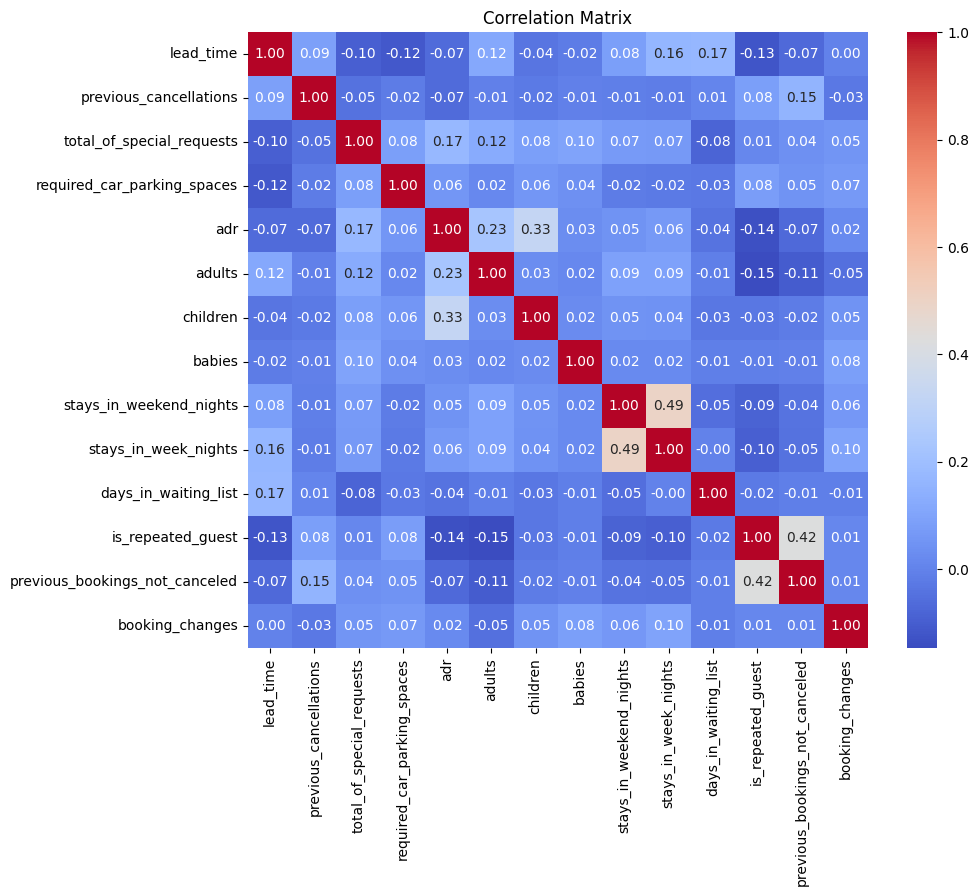

Cross-validation accuracy scores: [0.954922   0.95479585 0.95311186 0.95462574 0.95563499]
Average cross-validation accuracy: 95.46%
Standard deviation of the accuracy scores: 0.08%


In [29]:
# Numeric features that represent continuous or count data
numeric_features = [
    'lead_time', 
    'previous_cancellations', 
    'total_of_special_requests', 
    'required_car_parking_spaces',
    'adr',
    'adults',
    'children',
    'babies',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'days_in_waiting_list',
    'is_repeated_guest',
    'previous_bookings_not_canceled',
    'booking_changes',
]

# Categorical features that we need to one-hot encode
categorical_features = [
    'country', 
    'market_segment', 
    'customer_type', 
    'deposit_type', 
    'meal', 
    'reserved_room_type', 
    'assigned_room_type', 
    'distribution_channel',
    'hotel',
    'agent',
    'company',
    'reservation_status',
]

# Handling dates as either categorical or engineered features
date_features = [
    'arrival_date_year',  # Could be categorical if the year range is limited
    'arrival_date_month',  # Could be categorical with one-hot encoding
    'arrival_date_week_number',  # Could be treated as categorical or numeric
    'arrival_date_day_of_month',  # Likely numeric
    'reservation_status_date'  # This would need feature engineering, like extracting the day of the week, etc.
]

hotelbooking = pd.read_csv('hotel_bookings.csv')

hotelbooking = hotelbooking.dropna(subset=['country'])

hotelbooking = hotelbooking.fillna(0)

# 1. Correlation Between Features
# Calculate the correlation matrix for numeric features
corr_matrix = hotelbooking[numeric_features].corr() # pearson correlation coefficient by default
# the Pearson correlation coefficient is a measure of linear association between two continuous variables
# it doesn't apply to categorical data
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2. Impact on Target Variable
# Train a random forest model to get feature importances
# One-hot encode categorical features
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
          'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
hotelbooking['arrival_date_month'] = hotelbooking['arrival_date_month'].map(months)

# Convert 'reservation_status_date' to year, month, and day features
hotelbooking['reservation_status_date'] = pd.to_datetime(hotelbooking['reservation_status_date'])
hotelbooking['reservation_status_year'] = hotelbooking['reservation_status_date'].dt.year
hotelbooking['reservation_status_month'] = hotelbooking['reservation_status_date'].dt.month
hotelbooking['reservation_status_day'] = hotelbooking['reservation_status_date'].dt.day

# Update numeric_features list
numeric_features.extend(['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month',
                         'reservation_status_year', 'reservation_status_month', 'reservation_status_day'])

# Encode categorical features
hotelbooking_encoded = pd.get_dummies(hotelbooking, columns=categorical_features)

# Create feature matrix X and target vector y
X = hotelbooking_encoded[numeric_features + list(hotelbooking_encoded.columns[hotelbooking_encoded.columns.str.startswith('country')])]
y = hotelbooking_encoded['is_canceled']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1122)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1122)  

# Fit the RandomForestClassifier
model = RandomForestClassifier(random_state=1122)
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')

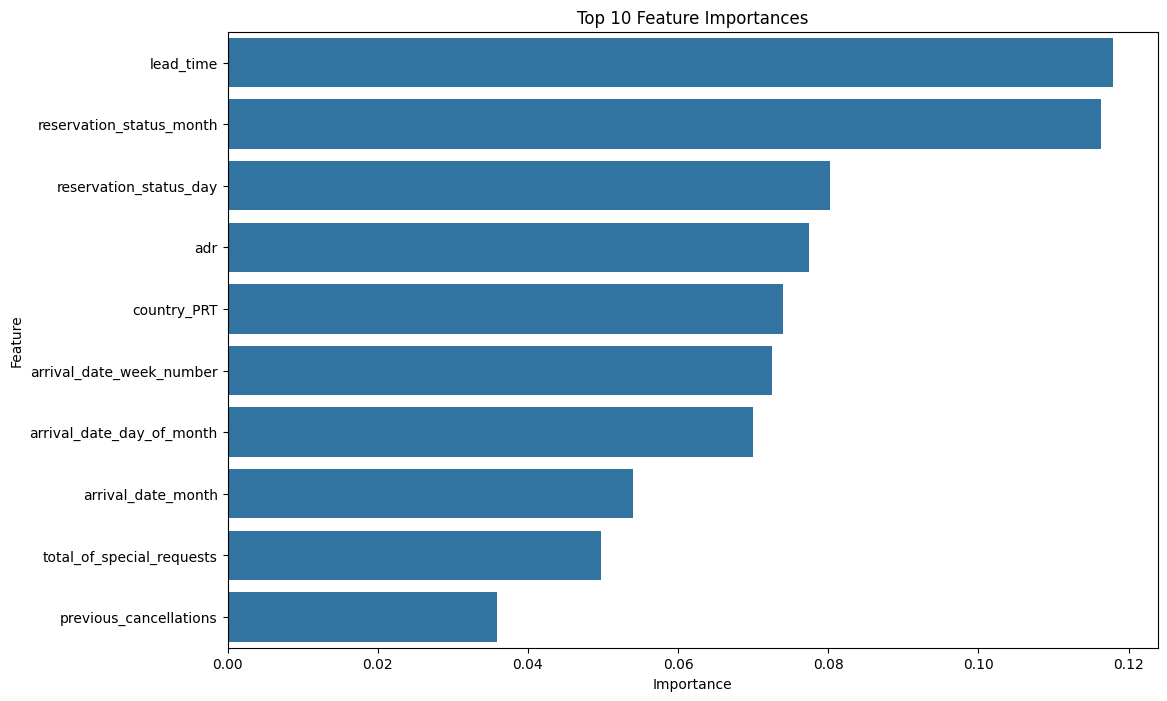

Training set accuracy: 100.00%
Validation set accuracy: 94.83%
Test set accuracy: 94.84%


In [30]:
# Ensure that selected_features contains the correct feature names
selected_features = X_train.columns.tolist()

# Fit the model
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Verify the lengths match
assert len(selected_features) == len(feature_importances), "The feature lists must be of the same length."

# Create a DataFrame to hold feature importances
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

train_accuracy = model.score(X_train, y_train)
print(f"Training set accuracy: {train_accuracy:.2%}")

val_accuracy = model.score(X_val, y_val)
print(f"Validation set accuracy: {val_accuracy:.2%}")

test_accuracy = model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2%}")


-----------------------------------------------------------------------------

As expected, we see that when we use all features to train the model and predict from the training set, we get perfect accuracy. We also notice that there is almost no overfitting as the validation set gives results very close to the training set results. Thus, the test results are almost perfect and reliable.

However, we used all features and this is not the best scenario. We want to be able to make predictions with as least features as possible.

-----------------------------------------------------------------------------

In [31]:
# 3. Independence Assumptions
# Calculate VIF for numeric features to check for multicollinearity
# VIF = Variance Inflation Factor ==> We use it to check for multicollinearity
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features
vif_data['VIF'] = [variance_inflation_factor(hotelbooking_encoded[numeric_features].values, i)
                   for i in range(len(numeric_features))]

print(vif_data)

                           feature           VIF
0                        lead_time  3.280589e+00
1           previous_cancellations  1.060579e+00
2        total_of_special_requests  1.699215e+00
3      required_car_parking_spaces  1.103247e+00
4                              adr  6.541651e+00
5                           adults  1.261651e+01
6                         children  1.205167e+00
7                           babies  1.024381e+00
8          stays_in_weekend_nights  2.533046e+00
9             stays_in_week_nights  3.753523e+00
10            days_in_waiting_list  1.073589e+00
11               is_repeated_guest  1.316218e+00
12  previous_bookings_not_canceled  1.257439e+00
13                 booking_changes  1.164241e+00
14               arrival_date_year  1.747457e+08
15              arrival_date_month  5.106222e+03
16        arrival_date_week_number  4.620907e+03
17       arrival_date_day_of_month  3.873139e+01
18         reservation_status_year  1.747357e+08
19        reservatio

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_pred = model.predict(X_val)

# Confusion Matrix on val data
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy Val: {accuracy}\nError Val: {1 - accuracy}\nBalanced Accuracy Val: {balanced_accuracy}")
print(f"Specificity Val: {specificity}\nSensitivity (Recall) Val: {recall}\nPrecision Val: {precision}")
print(f"F1 Score Val: {f1}")
print(f"ROC AUC Score Val: {roc_auc}") # it tells us how efficient the model is


print()

y_pred = model.predict(X_test)

# Confusion Matrix test data
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}\nError: {1 - accuracy}\nBalanced Accuracy: {balanced_accuracy}")
print(f"Specificity: {specificity}\nSensitivity (Recall): {recall}\nPrecision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}") # it tells us how efficient the model is

Accuracy Val: 0.948278037088432
Error Val: 0.051721962911568053
Balanced Accuracy Val: 0.9325009376082001
Specificity Val: 0.9935182091546942
Sensitivity (Recall) Val: 0.871483666061706
Precision Val: 0.9875321336760925
F1 Score Val: 0.9258857556037599
ROC AUC Score Val: 0.9325009376082001

Accuracy: 0.9484462385938354
Error: 0.05155376140616463
Balanced Accuracy: 0.9333573771577094
Specificity: 0.9929534930541575
Sensitivity (Recall): 0.8737612612612613
Precision: 0.986648016276704
F1 Score: 0.9267797419971333
ROC AUC Score: 0.9333573771577094


---------------------------------------------------------------------------
This data indicates that the model performs very well both on the validation set and the overall dataset, with high accuracy values of approximately 94.83% for both. The error rates are correspondingly low at around 5.17%. Balanced accuracy scores are also high (around 93.25% for both), suggesting that the model is effective at correctly identifying both positive and negative cases in a balanced manner. This is supported by high specificity (over 99.25%) and good sensitivity (around 87.26%), indicating the model's strong ability to correctly identify negative cases and a good performance in identifying positive cases as well. The high precision (around 98.66%) and F1 scores (around 92.67%) further reflect the model's overall effectiveness, balancing its precision and recall well. Finally, the ROC AUC scores (around 93.33%) for both the validation set and overall indicate excellent discrimination between the classes.

Conclusion --> Best model so far.

---------------------------------------------------------------------------

-----------------------------------------------------------------------
Now, we are going to apply PCA on all of the features so that we can use only the necessary features.
-----------------------------------------------------------------------

-----------------------------------------------------------------------

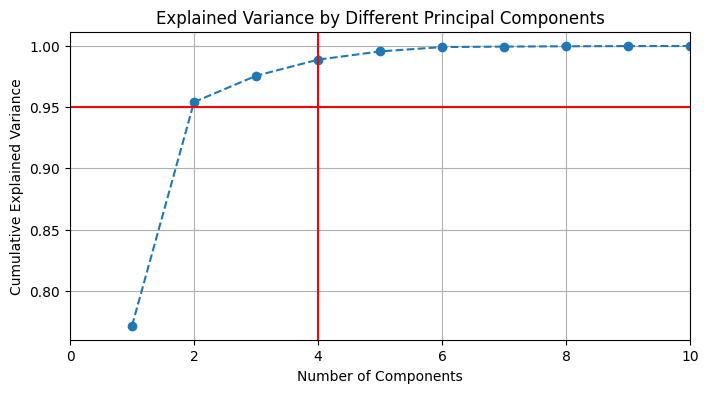

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% explained variance line
plt.axvline(x=4, color='r', linestyle='-')     # Line at the 'elbow'
plt.grid()

plt.xlim(0, 10)

plt.show()


In [34]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

In [35]:
# Transform the validation and test data using the same PCA transformation
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Now you can access the explained variance ratio from the PCA object
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.77172281 0.18235691]


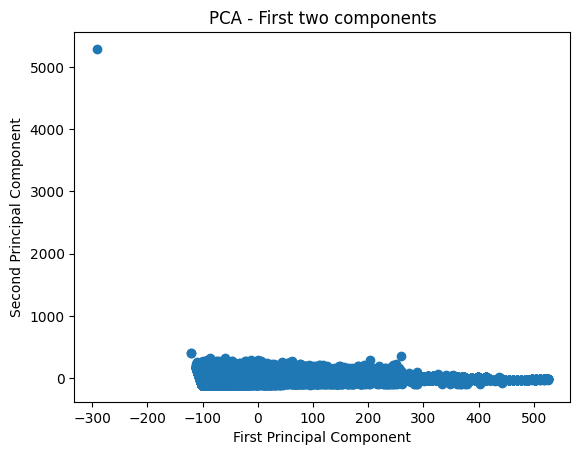

In [36]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA - First two components')
plt.show()

In [37]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('pca', PCA(n_components=2)),
    ('rf', RandomForestClassifier(random_state=1122))
])

# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')

Cross-validation accuracy scores: [0.80038686 0.80059712 0.80058873 0.79945332 0.80479394]
Average cross-validation accuracy: 80.12%
Standard deviation of the accuracy scores: 0.19%


-------------------------------------------------------------------------
Stable. Low variance. Good accuracy.

-------------------------------------------------------------------------

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.fit(X_train_pca, y_train)

# Predictions
y_pred = model.predict(X_val_pca)

# Confusion Matrix on val data
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy Val: {accuracy}\nError Val: {1 - accuracy}\nBalanced Accuracy Val: {balanced_accuracy}")
print(f"Specificity Val: {specificity}\nSensitivity (Recall) Val: {recall}\nPrecision Val: {precision}")
print(f"F1 Score Val: {f1}")
print(f"ROC AUC Score Val: {roc_auc}") # it tells us how efficient the model is

print()

y_pred = model.predict(X_test_pca)

# Confusion Matrix test data
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}\nError: {1 - accuracy}\nBalanced Accuracy: {balanced_accuracy}")
print(f"Specificity: {specificity}\nSensitivity (Recall): {recall}\nPrecision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}") # it tells us how efficient the model is

Accuracy Val: 0.7925234430848156
Error Val: 0.2074765569151844
Balanced Accuracy Val: 0.7646081669388283
Specificity Val: 0.8725693284330104
Sensitivity (Recall) Val: 0.656647005444646
Precision Val: 0.7522089397089398
F1 Score Val: 0.701187015503876
ROC AUC Score Val: 0.7646081669388283

Accuracy: 0.7903368235145705
Error: 0.20966317648542954
Balanced Accuracy: 0.7617110768912662
Specificity: 0.8747735051338836
Sensitivity (Recall): 0.6486486486486487
Precision: 0.7553107789142408
F1 Score: 0.697928026172301
ROC AUC Score: 0.7617110768912662


In [39]:
train_accuracy = model.score(X_train_pca, y_train)
print(f"Training set accuracy: {train_accuracy:.2%}")

val_accuracy = model.score(X_val_pca, y_val)
print(f"Validation set accuracy: {val_accuracy:.2%}")

test_accuracy = model.score(X_test_pca, y_test)
print(f"Test set accuracy: {test_accuracy:.2%}")

Training set accuracy: 99.99%
Validation set accuracy: 79.25%
Test set accuracy: 79.03%


----------------------------------------------------------------------------
By using PCA, we see noticeable overfitting.
The drop in performance on the validation (80.88%) and test sets (80.24%) indicates that the model is not generalizing as well to new, unseen data. This is a common challenge when the dimensionality reduction either retains too much complexity (leading to overfitting) or loses significant information pertinent to prediction (underfitting in a way).
PCA aims to reduce dimensions while retaining as much variance as possible, but this doesn’t always equate to retaining predictive accuracy. The key in PCA is to find the right number of components that capture the essential information without holding onto the noise and redundancy. If too many components are retained, the model may overfit; if too few are kept, it may miss critical information for making accurate predictions.

----------------------------------------------------------------------------


Below, we use a single tree with specific categorical and numeric features that make sense to us for deciding what affects which reservations are more likely to get canceled. It allows us to clearly see the decision-making in the tree.
------------------------------------------------------------------------------

------------------------------------------------------------------------------

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create feature matrix X and target vector y
X = hotelbooking_encoded[numeric_features + list(hotelbooking_encoded.columns[hotelbooking_encoded.columns.str.startswith('country')])]
y = hotelbooking_encoded['is_canceled']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1122)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1122)  


# Create and train the Decision Tree Classifier
model = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=20, 
    min_samples_leaf=10,  
    max_leaf_nodes=10,  
    min_impurity_decrease=0.01  
)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10,
                       min_impurity_decrease=0.01, min_samples_leaf=10,
                       min_samples_split=20)

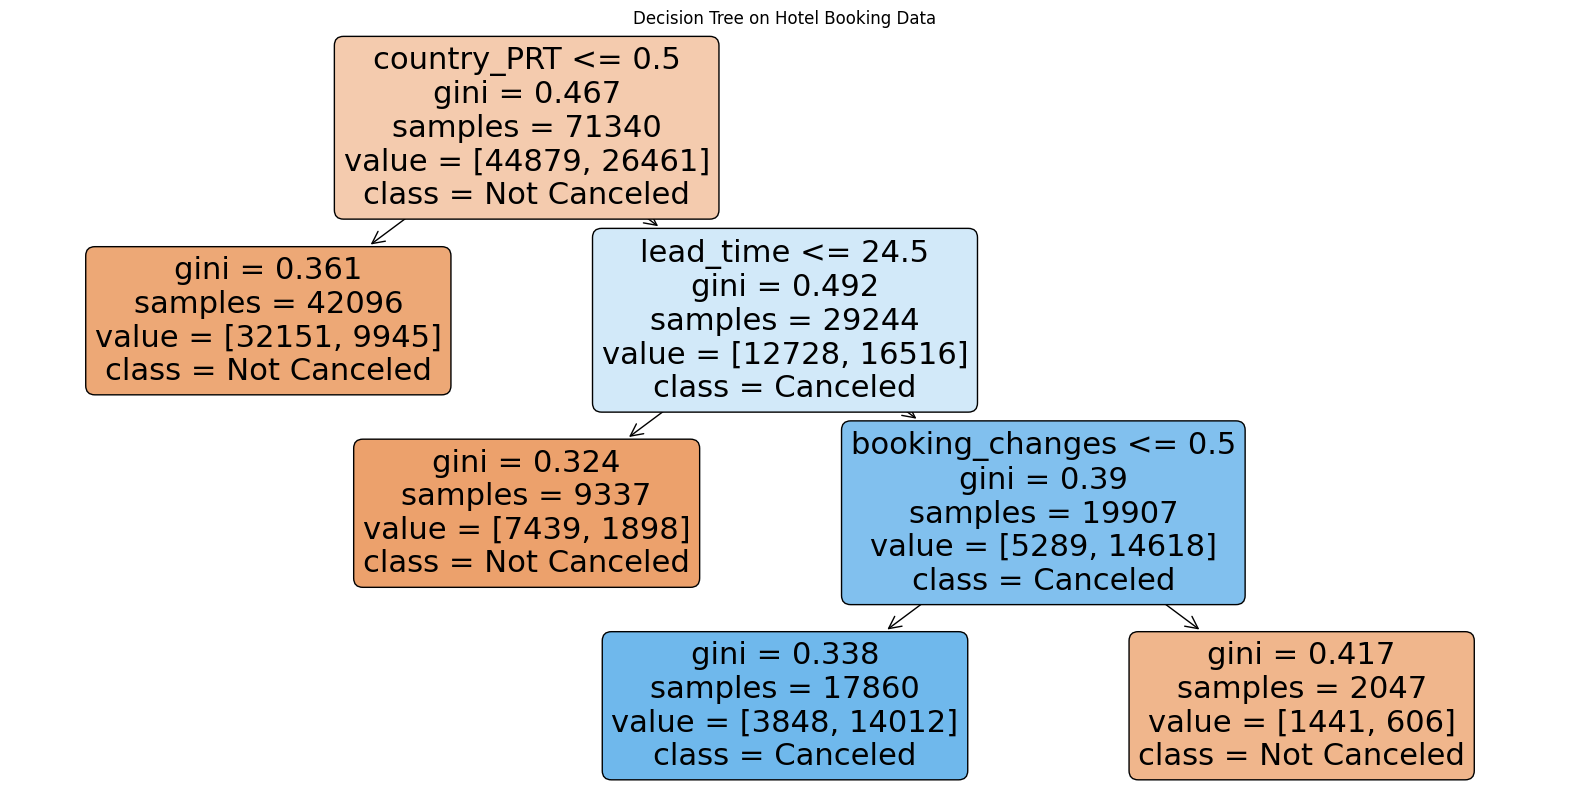

In [41]:
# Convert the column names to a list
feature_names_list = X.columns.tolist()

# Now use the list for plotting
plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(model, filled=True, rounded=True, feature_names=feature_names_list, class_names=['Not Canceled', 'Canceled'])
plt.title("Decision Tree on Hotel Booking Data")
plt.show()


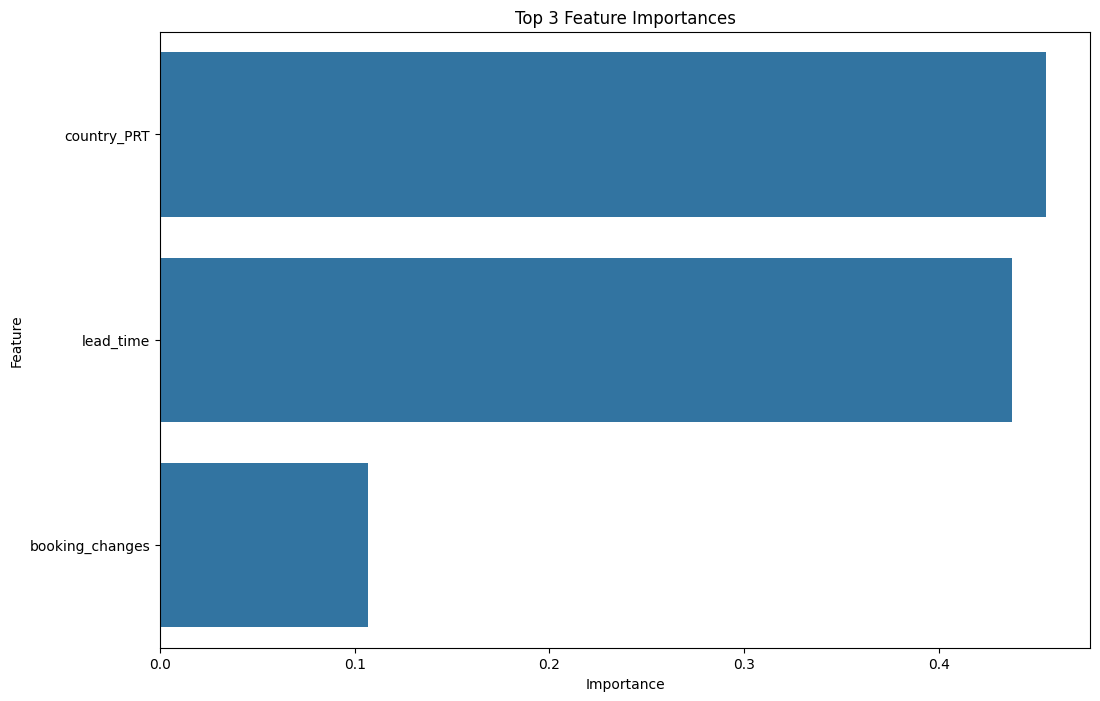

In [42]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to hold feature importances
features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(3))
plt.title('Top 3 Feature Importances')
plt.show()


In [43]:
# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1122)

# Calculate cross-validated accuracy scores
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Output the results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Average cross-validation accuracy: {cv_scores.mean():.2%}')
print(f'Standard deviation of the accuracy scores: {cv_scores.std():.2%}')

Cross-validation accuracy scores: [0.76645221 0.76186872 0.76534903 0.76610597 0.77417998]
Average cross-validation accuracy: 76.68%
Standard deviation of the accuracy scores: 0.40%


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_pred = model.predict(X_val)

# Confusion Matrix on val data
conf_matrix = confusion_matrix(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy Val: {accuracy}\nError Val: {1 - accuracy}\nBalanced Accuracy Val: {balanced_accuracy}")
print(f"Specificity Val: {specificity}\nSensitivity (Recall) Val: {recall}\nPrecision Val: {precision}")
print(f"F1 Score Val: {f1}")
print(f"ROC AUC Score Val: {roc_auc}") # it tells us how efficient the model is

print()

y_pred = model.predict(X_test)

# Confusion Matrix and other statistics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
balanced_accuracy = (recall + specificity) / 2
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}\nError: {1 - accuracy}\nBalanced Accuracy: {balanced_accuracy}")
print(f"Specificity: {specificity}\nSensitivity (Recall): {recall}\nPrecision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")


Accuracy Val: 0.774189478995837
Error Val: 0.225810521004163
Balanced Accuracy Val: 0.7240105315306192
Specificity Val: 0.9180755095222185
Sensitivity (Recall) Val: 0.52994555353902
Precision Val: 0.7921329264157342
F1 Score Val: 0.6350414571156722
ROC AUC Score Val: 0.7240105315306193

Accuracy: 0.7664522097472772
Error: 0.23354779025272276
Balanced Accuracy: 0.7163967092721875
Specificity: 0.9140997248506811
Sensitivity (Recall): 0.5186936936936937
Precision: 0.782534828406388
F1 Score: 0.6238656372748205
ROC AUC Score: 0.7241346263718923


The results indicate that the simple decision tree model demonstrates moderate overall performance with a validation accuracy of 77.42% and a slightly lower overall accuracy of 76.65%. The model shows a high specificity (over 91%), indicating it is effective at correctly identifying negative cases, but a lower sensitivity (around 52%), suggesting it's less adept at correctly identifying positive cases. The balanced accuracy, which is a more representative metric in case of imbalanced datasets, stands at around 72% for both validation and overall, further supporting the model's moderate performance. The F1 scores, which balance precision and recall, are relatively moderate (around 63%), and the similar ROC AUC scores (approximately 72%) indicate a decent but not exceptional ability to discriminate between the classes. This performance profile suggests room for improvement, possibly through model complexity adjustments or feature engineering.

Overall we see that our decision tree did okay (not good and not bad), and we can clearly see that Random Forest Classifier is a much better approach as it doesn't overfit the data and is choosing the best (agreed upon) class (in our case 'Canceled' or 'Not canceled').

-------------------------------------------------------------------------------

Now, we are going to apply K-Means to perform customer segmentation on the dataset.

For customer segmentation, we'll focus on features that could impact customer behavior and preferences such as 'country', 'market_segment', 'customer_type', 'previous_cancellations', and 'previous_bookings_not_canceled'.

We are going to first preprocess the data: 

- Categorical Variables: Convert categorical variables like 'country', 'market_segment', and 'customer_type' into numerical form using encoding techniques.

- Scaling: Scale the numerical data so that each feature contributes equally to the distance computations in K-Means.

--------------------------------------------------------------------------
We already did these parts earlier:

Explore Dataset:

Calculate the correlation between features and check their impact on the target variable, which could be a relevant metric such as booking cancellation or customer segmentation.
Test for independence between features, as highly correlated features might not be very informative for clustering.

Visualization Strategies:

Create correlation plots to visualize the relationships between features.
Employ dimensionality reduction techniques like PCA, UMAP, or t-SNE to visualize the data in two or three dimensions.

Cross-Validation Strategy:

For K-Means, traditional cross-validation is not applicable as it is an unsupervised method. Instead, we have to use techniques like the elbow method or silhouette score to determine the optimal number of clusters.

--------------------------------------------------------------------------

In [45]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd

# Numeric features that we can use directly
numeric_features = [
    'lead_time', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'total_of_special_requests', 
    'required_car_parking_spaces',
    'adr'
]

# Categorical features that we need to one-hot encode
categorical_features = [
    'country', 
    'market_segment', 
    'customer_type', 
    'deposit_type', 
    'meal', 
    'reserved_room_type', 
    'assigned_room_type', 
    'distribution_channel'
]

# Combine the features for transformation
features = numeric_features + categorical_features

# Prepare the ColumnTransformer for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Fit the preprocessor and transform the data
hotelbooking_prepared = preprocessor.fit_transform(hotelbooking[features])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


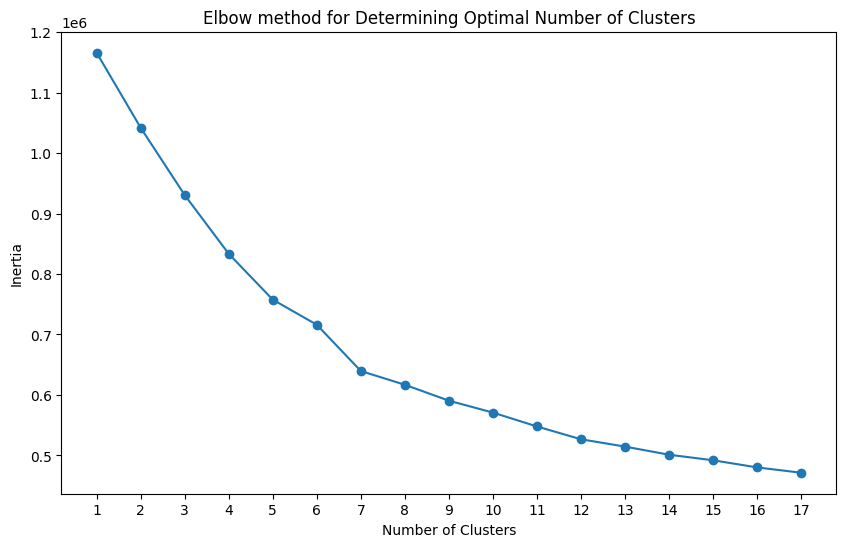

In [46]:
from sklearn.cluster import KMeans

cluster_range = range(1, 18)
inertias = []

# Calculate inertia for range of cluster values
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=1122)
    kmeans.fit(hotelbooking_prepared)
    inertias.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.show()

-----------------------------------------------------------------------------

We see that the optimal number of clusters is 7 as after this the slope gets flatter.

-----------------------------------------------------------------------------

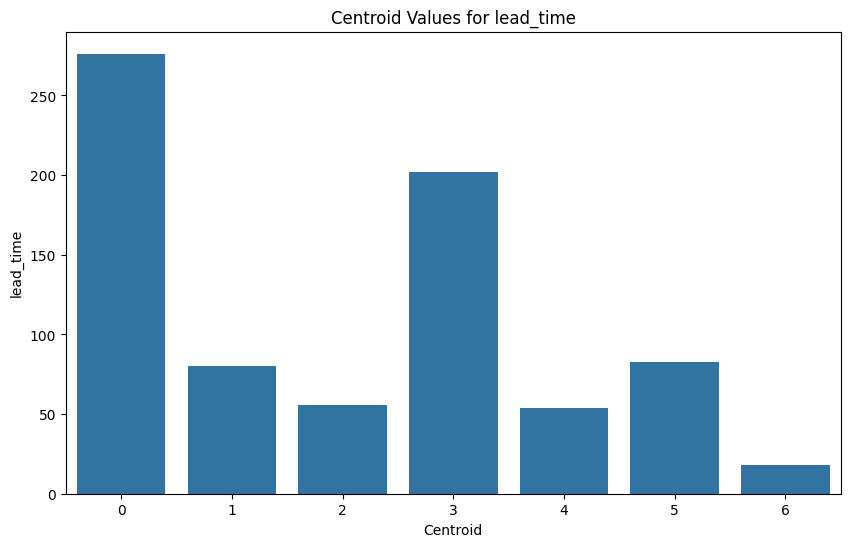

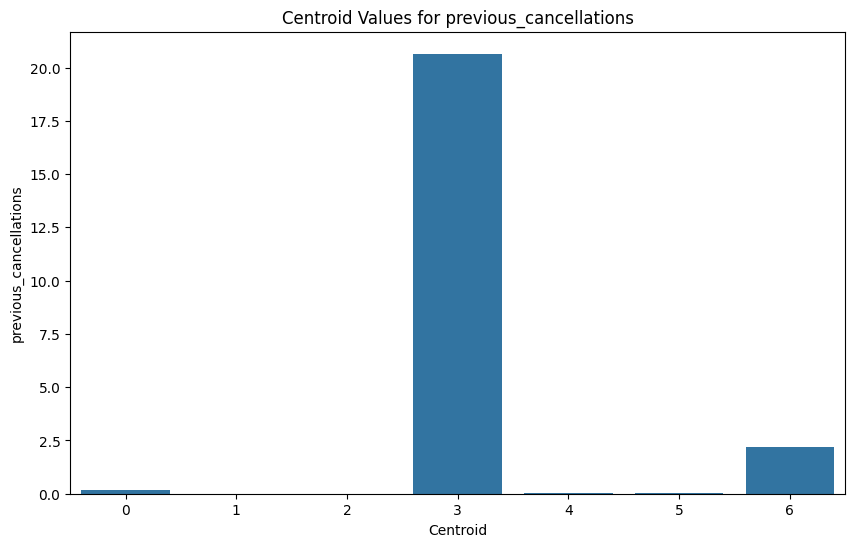

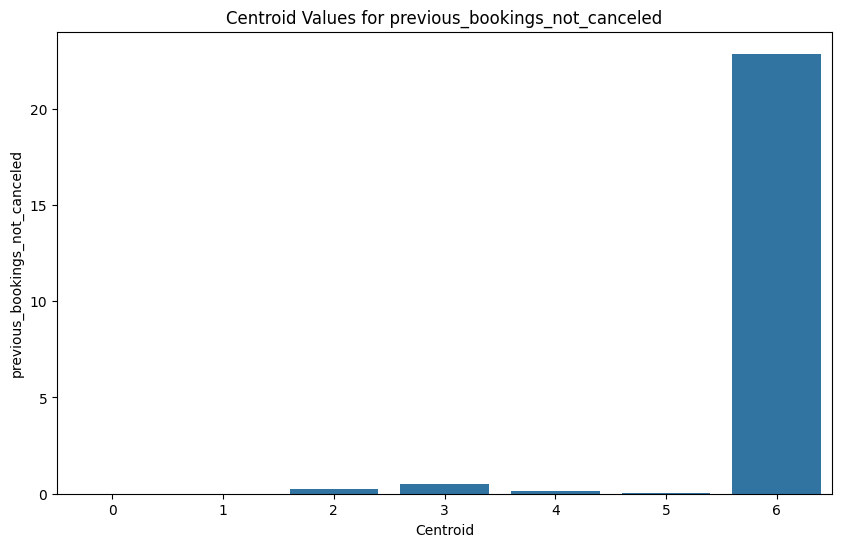

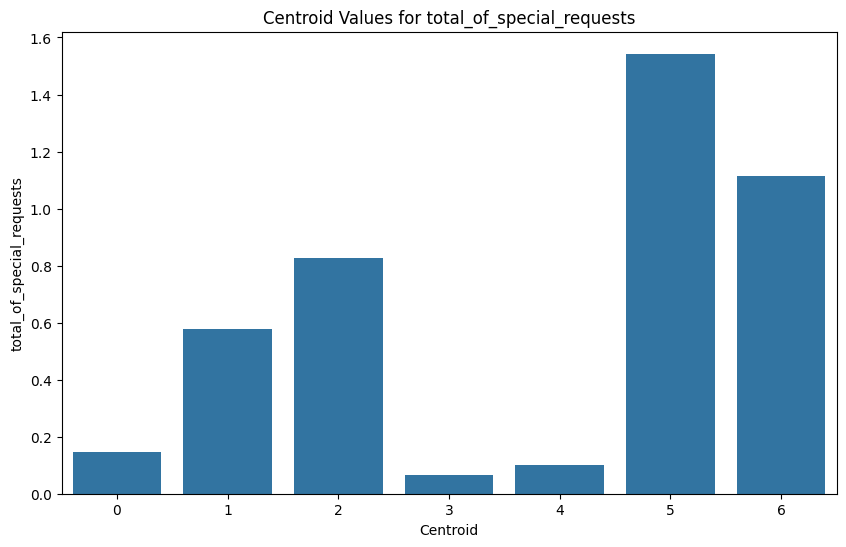

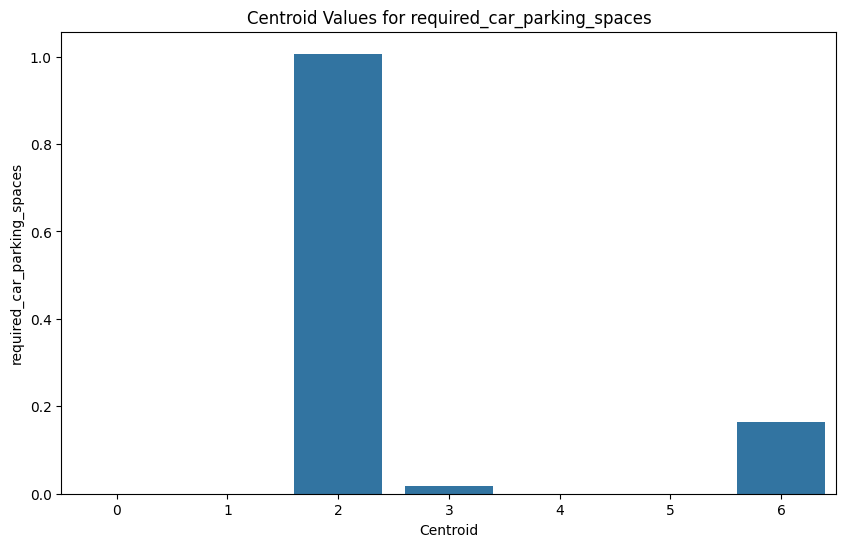

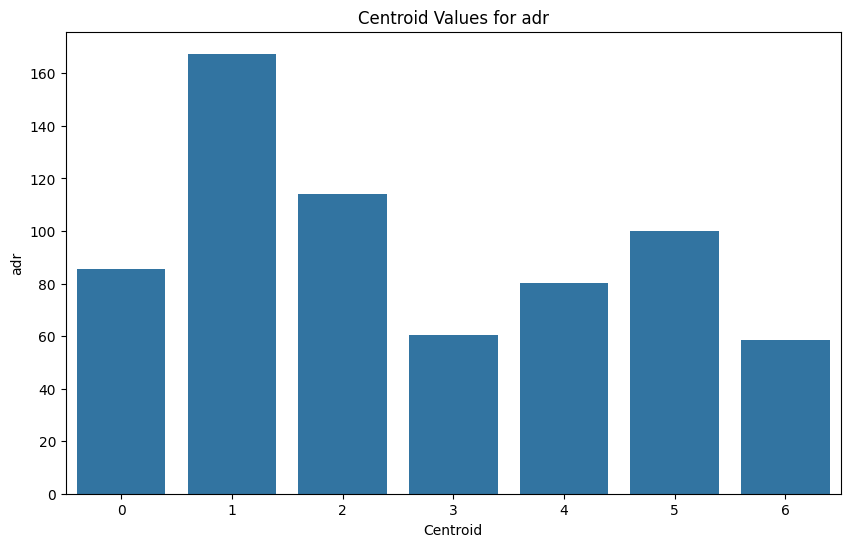

In [47]:
import seaborn as sns

kmeans = KMeans(n_clusters=7, random_state=1122)
kmeans.fit(hotelbooking_prepared)

# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Separate out the scaled numeric features from the centroids
# This number should be the number of numeric features we have
num_numeric_features = len(numeric_features)
centroids_scaled_features = centroids[:, :num_numeric_features]

# Get the StandardScaler from the ColumnTransformer
# The name 'num' corresponds to the name given to the numeric part of the ColumnTransformer
scaler = preprocessor.named_transformers_['num']

# Inverse transform the scaled numeric features of the centroids
centroids_original_numeric = scaler.inverse_transform(centroids_scaled_features)

# Separate out the scaled numeric features from the centroids
num_numeric_features = len(numeric_features)
centroids_scaled_features = centroids[:, :num_numeric_features]

scaler = preprocessor.named_transformers_['num']
centroids_original_numeric = scaler.inverse_transform(centroids_scaled_features)

# Convert the centroids of the numeric features back to a DataFrame for ease of plotting
centroids_df = pd.DataFrame(centroids_original_numeric, columns=numeric_features)

# Plotting bar charts for each centroid for the first few features
# We will plot bar charts for the first two features
for feature in numeric_features[:]:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=centroids_df.index, y=centroids_df[feature])
    plt.title(f'Centroid Values for {feature}')
    plt.xlabel('Centroid')
    plt.ylabel(feature)
    plt.show()

----------------------------------------------------------------------------------------------------------------------------
The clusters that have high lead time represent the guests who make reservations ahead of time. The clusters with a high value of previous cancellations, tend to cancel their reservations. Hotels will value the most the guests who book ahead of time and don't cancel. We can see that for the most part, the clusters (of guests) tend to book about 20-100 before showing up and they don't cancel their reservation.
Also, we can notice that customers who had previous reservations are not likely to have previous cancellations. + They tend to reserve 200+ days ahead.

We can also see that the customers who want parking spots, make special requests, and book about 50 days in advance, tend to not cancel their reservations. --> This data suggests that families are more responsible and show up when making a reservation (because they are usually the ones having all of those requirements).

----------------------------------------------------------------------------------------------------------------------------

In [4]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

# Perform TruncatedSVD with a high number of components
svd = TruncatedSVD(n_components=min(hotelbooking_prepared.shape) - 1)
hotelbooking_svd_full = svd.fit_transform(hotelbooking_prepared)

# Calculate the explained variance ratio for each component
explained_variance_ratio = svd.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance to find the number of components to use
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by SVD Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Now choose the number of components based on the plot
n_components_svd = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1

# Now we can perform TruncatedSVD with the chosen number of components
svd_reduced = TruncatedSVD(n_components=n_components_svd)
hotelbooking_svd_reduced = svd_reduced.fit_transform(hotelbooking_prepared)

# Continue with K-Means clustering using hotelbooking_svd_reduced as before


NameError: name 'hotelbooking_prepared' is not defined

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


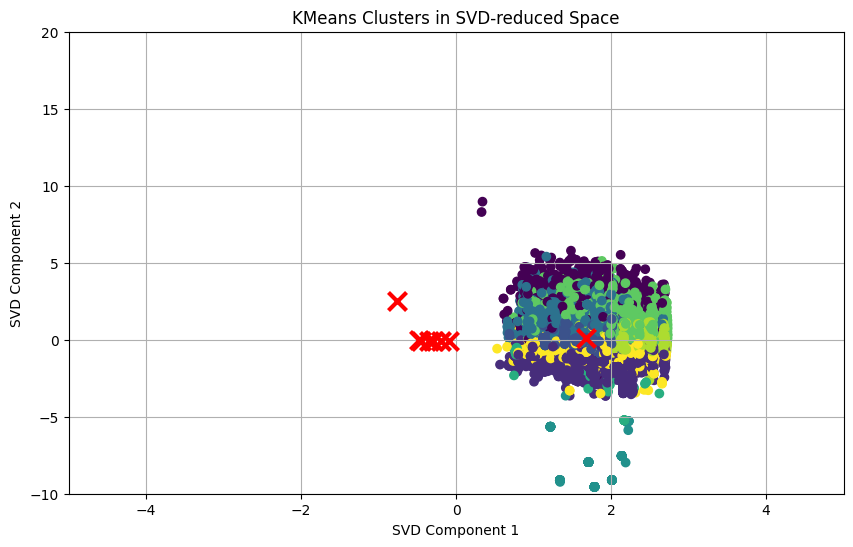

In [49]:
# Perform TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=10, random_state=1122)
hotelbooking_svd = svd.fit_transform(hotelbooking_prepared)

# Fit the KMeans model on the reduced data
kmeans = KMeans(n_clusters=9, random_state=1122)
kmeans.fit(hotelbooking_svd)

# Predict the cluster for each instance in the reduced data
cluster_assignments = kmeans.predict(hotelbooking_svd)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(hotelbooking_svd[:, 0], hotelbooking_svd[:, 1], c=cluster_assignments, cmap='viridis', marker='o')

# Plot the centroids of the clusters in the reduced space
centroids_reduced = svd.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)

plt.title('KMeans Clusters in SVD-reduced Space')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid(True)

plt.xlim(-5, 5)
plt.ylim(-10, 20)

plt.show()

-------------------------------------------------------------------------------------------------------------------------------------
Despite the graphs showing multiple clusters, after actually plotting the clusters and their centroids, we can see that there isn't an obvious split between the different clusters. Thus, instead of K-Means, we should explore the clusters using DBSCAN which might be more suitable for this dataset. However, DBSCAN is computationally expensive and after running it for 10 minutes with no output, we decided to continue without further cluster testing.

-------------------------------------------------------------------------------------------------------------------------------------


--------------------------------------------------------------------------------

We tried to plot the clusters without reducing dimensionality. We decided to only use the indices of the features with the highest variance. However, we run into a problem - we first had to convert the sparse matrix to a dense format which is computationally expensive and it takes very long time. Thus, it's not worth it.

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
We will now proceed with our next model -> Neural Network.

--------------------------------------------------------------------------------

In [6]:
# Numeric features that represent continuous or count data
numeric_features = [
    'lead_time', 
    'previous_cancellations', 
    'total_of_special_requests', 
    'required_car_parking_spaces',
    'adults',
    'children',
    'babies',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'days_in_waiting_list',
    'is_repeated_guest',
    'previous_bookings_not_canceled',
    'booking_changes',
    'adr'
]

# Categorical features that we need to one-hot encode
categorical_features = [
    'country', 
    'market_segment', 
    'customer_type', 
    'deposit_type', 
    'meal', 
    'reserved_room_type', 
    'assigned_room_type', 
    'distribution_channel',
    'hotel',
    'agent',
    'company',
    'reservation_status',
]

# Handling dates as either categorical or engineered features
date_features = [
    'arrival_date_year',  # Could be categorical if the year range is limited
    'arrival_date_month',  # Could be categorical with one-hot encoding
    'arrival_date_week_number',  # Could be treated as categorical or numeric
    'arrival_date_day_of_month',  # Likely numeric
    'reservation_status_date'  # This would need feature engineering, like extracting the day of the week, etc.
]

hotelbooking = pd.read_csv('hotel_bookings.csv')

hotelbooking = hotelbooking.dropna(subset=['country'])

hotelbooking = hotelbooking.fillna(0)

# 2. Impact on Target Variable
# Train a random forest model to get feature importances
# One-hot encode categorical features
months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
          'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
hotelbooking['arrival_date_month'] = hotelbooking['arrival_date_month'].map(months)

# Convert 'reservation_status_date' to year, month, and day features
hotelbooking['reservation_status_date'] = pd.to_datetime(hotelbooking['reservation_status_date'])
hotelbooking['reservation_status_year'] = hotelbooking['reservation_status_date'].dt.year
hotelbooking['reservation_status_month'] = hotelbooking['reservation_status_date'].dt.month
hotelbooking['reservation_status_day'] = hotelbooking['reservation_status_date'].dt.day

# Update numeric_features list
numeric_features.extend(['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month',
                         'reservation_status_year', 'reservation_status_month', 'reservation_status_day'])

# Encode categorical features
hotelbooking_encoded = pd.get_dummies(hotelbooking, columns=categorical_features)

# Create feature matrix X and target vector y
X = hotelbooking_encoded[numeric_features + list(hotelbooking_encoded.columns[hotelbooking_encoded.columns.str.startswith('country')])]
y = hotelbooking_encoded['is_canceled']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1122)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1122)  

In [7]:
from sklearn.preprocessing import StandardScaler

# Convert features and target to float32
X = X.astype('float32')
y = y.astype('float32')
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

scaler = StandardScaler()

# Fit and transform scaler on the training data
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])

# Apply the same transformation to validation and test data
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Pass early stopping as a callback to the 'fit' method within the 'create_model' function
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer for regression

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


2023-12-01 00:21:09.988919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Wrap the model using KerasRegressor
estimator = KerasRegressor(build_fn=create_model, epochs=10, batch_size=5, verbose=0)

In [25]:
# Sample a smaller subset for training - adjust the test_size to control the subset size
X_train_small, _, y_train_small, _ = train_test_split(X, y, test_size=0.8, random_state=1122)

# If you want to use a smaller validation set as well
X_val_small, _, y_val_small, _ = train_test_split(X_val, y_val, test_size=0.8, random_state=1122)

# If you want to use a smaller validation set as well
X_test_small, _, y_test_small, _ = train_test_split(X_test, y_test, test_size=0.8, random_state=1122)


# Fit the model on the smaller subset
estimator.fit(X_train_small, y_train_small, validation_data=(X_val_small, y_val_small))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


KerasRegressor(
	model=None
	build_fn=<function create_model at 0x7fd6e5f89c10>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

In [26]:
y_pred_small = estimator.predict(X_val_small)

# Function to convert probabilities to binary
def convert_to_binary(y, threshold=0.5):
    return [1 if i > threshold else 0 for i in y]

# Convert probabilistic predictions to binary (if needed)
y_pred_val_binary = convert_to_binary(y_pred_small)
y_pred_test_binary = convert_to_binary(estimator.predict(X_test_small))

# Now apply the metrics
# Validation Data Metrics
conf_matrix_val = confusion_matrix(y_val_small, y_pred_val_binary)
accuracy_val = accuracy_score(y_val_small, y_pred_val_binary)
precision_val = precision_score(y_val_small, y_pred_val_binary)
recall_val = recall_score(y_val_small, y_pred_val_binary)
specificity_val = conf_matrix_val[0,0] / (conf_matrix_val[0,0] + conf_matrix_val[0,1])
balanced_accuracy_val = (recall_val + specificity_val) / 2
f1_val = f1_score(y_val_small, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val_small, y_pred_val_binary)

print(f"Validation Data Metrics:")
print(f"Accuracy: {accuracy_val}\nError: {1 - accuracy_val}\nBalanced Accuracy: {balanced_accuracy_val}")
print(f"Specificity: {specificity_val}\nSensitivity (Recall): {recall_val}\nPrecision: {precision_val}")
print(f"F1 Score: {f1_val}")
print(f"ROC AUC Score: {roc_auc_val}")

print()

# Test Data Metrics
conf_matrix_test = confusion_matrix(y_test_small, y_pred_test_binary)
accuracy_test = accuracy_score(y_test_small, y_pred_test_binary)
precision_test = precision_score(y_test_small, y_pred_test_binary)
recall_test = recall_score(y_test_small, y_pred_test_binary)
specificity_test = conf_matrix_test[0,0] / (conf_matrix_test[0,0] + conf_matrix_test[0,1])
balanced_accuracy_test = (recall_test + specificity_test) / 2
f1_test = f1_score(y_test_small, y_pred_test_binary)
roc_auc_test = roc_auc_score(y_test_small, y_pred_test_binary)

print(f"Test Data Metrics:")
print(f"Accuracy: {accuracy_test}\nError: {1 - accuracy_test}\nBalanced Accuracy: {balanced_accuracy_test}")
print(f"Specificity: {specificity_test}\nSensitivity (Recall): {recall_test}\nPrecision: {precision_test}")
print(f"F1 Score: {f1_test}")
print(f"ROC AUC Score: {roc_auc_test}")

Validation Data Metrics:
Accuracy: 0.6187973086627419
Error: 0.38120269133725815
Balanced Accuracy: 0.5
Specificity: 1.0
Sensitivity (Recall): 0.0
Precision: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5

Test Data Metrics:
Accuracy: 0.6312026913372581
Error: 0.36879730866274185
Balanced Accuracy: 0.5
Specificity: 1.0
Sensitivity (Recall): 0.0
Precision: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.neural_network import MLPRegressor

# Create and fit the neural network regression model
model = MLPRegressor(
    hidden_layer_sizes=(15, 10, 5),
    activation='tanh',  # Try 'tanh' or 'logistic'
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.0001,
    max_iter=200, 
    early_stopping=True, 
    random_state=1122
)

model.fit(X_train, y_train)


MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(15, 10, 5), learning_rate_init=0.0001,
             random_state=1122)

In [32]:
# Function to convert probabilities to binary
def convert_to_binary(y, threshold=0.5):
    return [1 if i > threshold else 0 for i in y]

# Convert probabilistic predictions to binary (if needed)
y_pred_val_binary = convert_to_binary(model.predict(X_val_small))
y_pred_test_binary = convert_to_binary(model.predict(X_test_small))

# Now apply the metrics
# Validation Data Metrics
conf_matrix_val = confusion_matrix(y_val_small, y_pred_val_binary)
accuracy_val = accuracy_score(y_val_small, y_pred_val_binary)
precision_val = precision_score(y_val_small, y_pred_val_binary)
recall_val = recall_score(y_val_small, y_pred_val_binary)
specificity_val = conf_matrix_val[0,0] / (conf_matrix_val[0,0] + conf_matrix_val[0,1])
balanced_accuracy_val = (recall_val + specificity_val) / 2
f1_val = f1_score(y_val_small, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val_small, y_pred_val_binary)

print(f"Validation Data Metrics:")
print(f"Accuracy: {accuracy_val}\nError: {1 - accuracy_val}\nBalanced Accuracy: {balanced_accuracy_val}")
print(f"Specificity: {specificity_val}\nSensitivity (Recall): {recall_val}\nPrecision: {precision_val}")
print(f"F1 Score: {f1_val}")
print(f"ROC AUC Score: {roc_auc_val}")

print()

# Test Data Metrics
conf_matrix_test = confusion_matrix(y_test_small, y_pred_test_binary)
accuracy_test = accuracy_score(y_test_small, y_pred_test_binary)
precision_test = precision_score(y_test_small, y_pred_test_binary)
recall_test = recall_score(y_test_small, y_pred_test_binary)
specificity_test = conf_matrix_test[0,0] / (conf_matrix_test[0,0] + conf_matrix_test[0,1])
balanced_accuracy_test = (recall_test + specificity_test) / 2
f1_test = f1_score(y_test_small, y_pred_test_binary)
roc_auc_test = roc_auc_score(y_test_small, y_pred_test_binary)

print(f"Test Data Metrics:")
print(f"Accuracy: {accuracy_test}\nError: {1 - accuracy_test}\nBalanced Accuracy: {balanced_accuracy_test}")
print(f"Specificity: {specificity_test}\nSensitivity (Recall): {recall_test}\nPrecision: {precision_test}")
print(f"F1 Score: {f1_test}")
print(f"ROC AUC Score: {roc_auc_test}")

Validation Data Metrics:
Accuracy: 0.9976170451359686
Error: 0.0023829548640313947
Balanced Accuracy: 0.9970044907192026
Specificity: 0.9995481247175779
Sensitivity (Recall): 0.9944608567208272
Precision: 0.9992578849721707
F1 Score: 0.9968535998519341
ROC AUC Score: 0.9970044907192026

Test Data Metrics:
Accuracy: 0.9985281749369218
Error: 0.0014718250630781915
Balanced Accuracy: 0.998360082256071
Specificity: 0.9990006662225184
Sensitivity (Recall): 0.9977194982896237
Precision: 0.9982886480319453
F1 Score: 0.9980039920159681
ROC AUC Score: 0.9983600822560711


In [33]:
from sklearn.neural_network import MLPRegressor

# Create and fit the neural network regression model
model = MLPRegressor(
    hidden_layer_sizes=(15, 10, 5),
    activation='logistic',  # Try 'tanh' or 'logistic'
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.0001,
    max_iter=200, 
    early_stopping=True, 
    random_state=1122
)

model.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(15, 10, 5), learning_rate_init=0.0001,
             random_state=1122)

In [34]:
# Function to convert probabilities to binary
def convert_to_binary(y, threshold=0.5):
    return [1 if i > threshold else 0 for i in y]

# Convert probabilistic predictions to binary (if needed)
y_pred_val_binary = convert_to_binary(model.predict(X_val_small))
y_pred_test_binary = convert_to_binary(model.predict(X_test_small))

# Now apply the metrics
# Validation Data Metrics
conf_matrix_val = confusion_matrix(y_val_small, y_pred_val_binary)
accuracy_val = accuracy_score(y_val_small, y_pred_val_binary)
precision_val = precision_score(y_val_small, y_pred_val_binary)
recall_val = recall_score(y_val_small, y_pred_val_binary)
specificity_val = conf_matrix_val[0,0] / (conf_matrix_val[0,0] + conf_matrix_val[0,1])
balanced_accuracy_val = (recall_val + specificity_val) / 2
f1_val = f1_score(y_val_small, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val_small, y_pred_val_binary)

print(f"Validation Data Metrics:")
print(f"Accuracy: {accuracy_val}\nError: {1 - accuracy_val}\nBalanced Accuracy: {balanced_accuracy_val}")
print(f"Specificity: {specificity_val}\nSensitivity (Recall): {recall_val}\nPrecision: {precision_val}")
print(f"F1 Score: {f1_val}")
print(f"ROC AUC Score: {roc_auc_val}")

print()

# Test Data Metrics
conf_matrix_test = confusion_matrix(y_test_small, y_pred_test_binary)
accuracy_test = accuracy_score(y_test_small, y_pred_test_binary)
precision_test = precision_score(y_test_small, y_pred_test_binary)
recall_test = recall_score(y_test_small, y_pred_test_binary)
specificity_test = conf_matrix_test[0,0] / (conf_matrix_test[0,0] + conf_matrix_test[0,1])
balanced_accuracy_test = (recall_test + specificity_test) / 2
f1_test = f1_score(y_test_small, y_pred_test_binary)
roc_auc_test = roc_auc_score(y_test_small, y_pred_test_binary)

print(f"Test Data Metrics:")
print(f"Accuracy: {accuracy_test}\nError: {1 - accuracy_test}\nBalanced Accuracy: {balanced_accuracy_test}")
print(f"Specificity: {specificity_test}\nSensitivity (Recall): {recall_test}\nPrecision: {precision_test}")
print(f"F1 Score: {f1_test}")
print(f"ROC AUC Score: {roc_auc_test}")

Validation Data Metrics:
Accuracy: 0.944210821418559
Error: 0.055789178581440946
Balanced Accuracy: 0.9278040796929117
Specificity: 0.9959331224582015
Sensitivity (Recall): 0.8596750369276218
Precision: 0.9923273657289002
F1 Score: 0.9212504946576968
ROC AUC Score: 0.9278040796929117

Test Data Metrics:
Accuracy: 0.9480656013456686
Error: 0.05193439865433136
Balanced Accuracy: 0.9311301017869501
Specificity: 0.9956695536309127
Sensitivity (Recall): 0.8665906499429875
Precision: 0.9915198956294846
F1 Score: 0.9248554913294798
ROC AUC Score: 0.9311301017869501


In [35]:
from sklearn.neural_network import MLPRegressor

# Create and fit the neural network regression model
model = MLPRegressor(
    hidden_layer_sizes=(20, 15, 10, 5),
    activation='relu',  
    solver='adam',
    alpha=0.01,
    learning_rate_init=0.01,
    max_iter=200, 
    early_stopping=True, 
    random_state=1122
)

model.fit(X_train, y_train)


MLPRegressor(alpha=0.01, early_stopping=True,
             hidden_layer_sizes=(20, 15, 10, 5), learning_rate_init=0.01,
             random_state=1122)

In [36]:
# Function to convert probabilities to binary
def convert_to_binary(y, threshold=0.5):
    return [1 if i > threshold else 0 for i in y]

# Convert probabilistic predictions to binary (if needed)
y_pred_val_binary = convert_to_binary(model.predict(X_val_small))
y_pred_test_binary = convert_to_binary(model.predict(X_test_small))

# Now apply the metrics
# Validation Data Metrics
conf_matrix_val = confusion_matrix(y_val_small, y_pred_val_binary)
accuracy_val = accuracy_score(y_val_small, y_pred_val_binary)
precision_val = precision_score(y_val_small, y_pred_val_binary)
recall_val = recall_score(y_val_small, y_pred_val_binary)
specificity_val = conf_matrix_val[0,0] / (conf_matrix_val[0,0] + conf_matrix_val[0,1])
balanced_accuracy_val = (recall_val + specificity_val) / 2
f1_val = f1_score(y_val_small, y_pred_val_binary)
roc_auc_val = roc_auc_score(y_val_small, y_pred_val_binary)

print(f"Validation Data Metrics:")
print(f"Accuracy: {accuracy_val}\nError: {1 - accuracy_val}\nBalanced Accuracy: {balanced_accuracy_val}")
print(f"Specificity: {specificity_val}\nSensitivity (Recall): {recall_val}\nPrecision: {precision_val}")
print(f"F1 Score: {f1_val}")
print(f"ROC AUC Score: {roc_auc_val}")

print()

# Test Data Metrics
conf_matrix_test = confusion_matrix(y_test_small, y_pred_test_binary)
accuracy_test = accuracy_score(y_test_small, y_pred_test_binary)
precision_test = precision_score(y_test_small, y_pred_test_binary)
recall_test = recall_score(y_test_small, y_pred_test_binary)
specificity_test = conf_matrix_test[0,0] / (conf_matrix_test[0,0] + conf_matrix_test[0,1])
balanced_accuracy_test = (recall_test + specificity_test) / 2
f1_test = f1_score(y_test_small, y_pred_test_binary)
roc_auc_test = roc_auc_score(y_test_small, y_pred_test_binary)

print(f"Test Data Metrics:")
print(f"Accuracy: {accuracy_test}\nError: {1 - accuracy_test}\nBalanced Accuracy: {balanced_accuracy_test}")
print(f"Specificity: {specificity_test}\nSensitivity (Recall): {recall_test}\nPrecision: {precision_test}")
print(f"F1 Score: {f1_test}")
print(f"ROC AUC Score: {roc_auc_test}")

Validation Data Metrics:
Accuracy: 0.9974768713204374
Error: 0.002523128679562614
Balanced Accuracy: 0.9971781990533981
Specificity: 0.9984184365115228
Sensitivity (Recall): 0.9959379615952733
Precision: 0.9974112426035503
F1 Score: 0.9966740576496674
ROC AUC Score: 0.9971781990533981

Test Data Metrics:
Accuracy: 0.9976871320437343
Error: 0.0023128679562657295
Balanced Accuracy: 0.9974568455693165
Specificity: 0.9983344437041972
Sensitivity (Recall): 0.9965792474344356
Precision: 0.9971477467199087
F1 Score: 0.9968634160250927
ROC AUC Score: 0.9974568455693165


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a set of hyperparameters for grid search
param_grid = {
    'solver': ['adam', 'sgd', 'lbfgs'],
    'hidden_layer_sizes': [(20, 15, 10, 5), (15, 10, 5), (20, 10), (10,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    # Add more parameters if needed
}

# Create a GridSearchCV object
grid = GridSearchCV(MLPRegressor(max_iter=200, early_stopping=True, random_state=1122), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit grid search
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

We tried to finetune the hyperparameters by running GridSearch. However, due to the complexity of the data and the model, it took too long to run. Thus, we decided against it but we left our code above.